device = cpu
total training batch number: 600
total testing batch number: 100


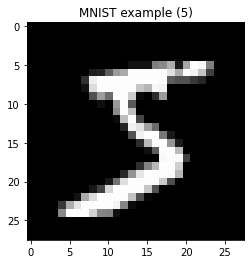

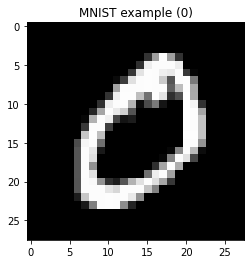

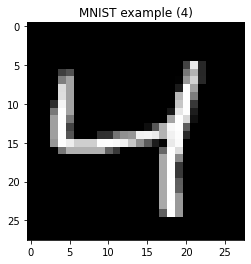

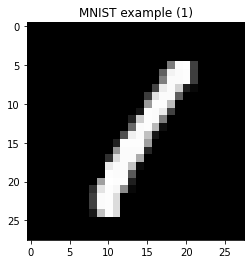

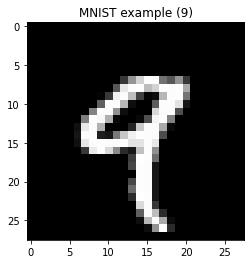

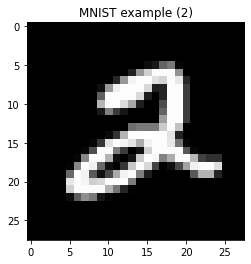

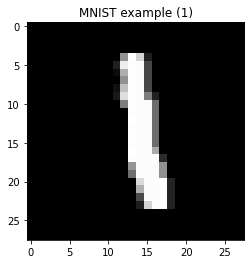

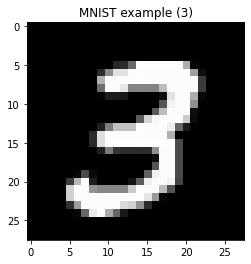

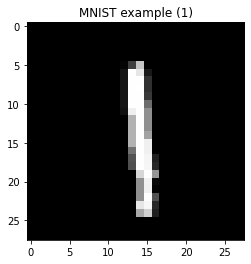

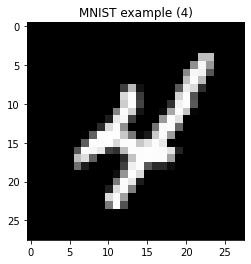

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
# import datasets 
from torchvision import datasets, transforms
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.001 # try 0.0005 for BiLSTM

trans = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize( (0.1307,),(0.3081,))])

train_set = datasets.MNIST( './data', train=True, transform=trans, download=True )
test_set = datasets.MNIST( './data', train=False, transform=trans, download=True )

# define data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))

# display some images
# for an alternative see https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
for ii in range(10):
    imshow(train_set.data[ii,:,:] , title='MNIST example ({})'.format(train_set.targets[ii]))
# to display 10 random images from training set
#import random # put it at the beggining of the program
#for ii in random.sample(range(len(train_set)), 10):
#    imshow(train_set.data[ii,:,:] , title='MNIST example ({})'.format(train_set.targets[ii]))
plt.close()

In [2]:
DATA_SIZE = 784
NUM_HIDDEN_1 = 256 # try 512
NUM_HIDDEN_2 = 256
NUM_CLASSES = 10

NUM_CONV_1=10 # try 32
NUM_CONV_2=20 # try 64
NUM_FC=500 # try 1024

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,NUM_CONV_1,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        # self.drop = nn.Dropout2d()
        self.fc_1 = nn.Linear(4*4*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        # x = F.relu(self.drop(self.conv_2(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,4*4*NUM_CONV_2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
        # en utilisant loss = F.nll_loss(output, target) on peut faire
        # return F.log_softmax(x, dim=1)
        
# define model (choose MLP or CNN)
is_cnn=True
#model = RegSoftNet()
#model = MLPNet()
model = CNNNet(); is_cnn=True
model.to(device) # puts model on GPU / CPU

CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)

In [3]:
# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

# main loop (train+test)
for epoch in range(10):
    # training
    model.train() # mode "train" agit sur "dropout" ou "batchnorm"
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
    len(test_loader.dataset), taux_classif, 100.-taux_classif))

epoch 0 batch 0 [0/60000] training loss: 2.3276169300079346
epoch 0 batch 100 [10000/60000] training loss: 0.289987176656723
epoch 0 batch 200 [20000/60000] training loss: 0.0900498777627945
epoch 0 batch 300 [30000/60000] training loss: 0.18278367817401886
epoch 0 batch 400 [40000/60000] training loss: 0.1114015132188797
epoch 0 batch 500 [50000/60000] training loss: 0.054078053683042526
Accuracy: 9729/10000 (tx 97.29%, err 2.71%)

epoch 1 batch 0 [0/60000] training loss: 0.05369734391570091
epoch 1 batch 100 [10000/60000] training loss: 0.08160455524921417
epoch 1 batch 200 [20000/60000] training loss: 0.056012559682130814
epoch 1 batch 300 [30000/60000] training loss: 0.03427441418170929
epoch 1 batch 400 [40000/60000] training loss: 0.08225703239440918
epoch 1 batch 500 [50000/60000] training loss: 0.021038878709077835
Accuracy: 9854/10000 (tx 98.54%, err 1.46%)

epoch 2 batch 0 [0/60000] training loss: 0.07673277705907822
epoch 2 batch 100 [10000/60000] training loss: 0.0209580976

In [4]:
if is_cnn == True:
    filename = 'model_cnn.pth'
    torch.save(model.state_dict(), filename)
    print("saved model to {}".format(filename))

saved model to model_cnn.pth
